In [248]:
from numpy import *
from numpy.random import *
from LabFuncs import *
from Params import *
from WIMPFuncs import *
import pandas
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from scipy.stats import norm
import pandas
# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)
sig_iso = array([150.0,120.0,120.0])



import healpy as hp
nside = 64
npix = 12*nside**2
dpix = 4*pi/(npix*1.0)
x_pix = zeros(shape=(npix,3))
for i in range(0,npix):
    x_pix[i,:] = hp.pix2vec(nside, i)
    
def EarthVector1(day):
    a_earth = AstronomicalUnit/1.0e3
    tp = 3
    lamb_p = 102*pi/180
    g = w_p*(day-tp)
    nu = g + 2.*eccentricity*sin(g)*(5.0/4.0)+eccentricity**2.0*sin(2*g)
    r = a_earth*(1-eccentricity**2.0)/(1+eccentricity*cos(nu))
    r_earth = r*(-sin(lamb_p+nu)*e1 + cos(lamb_p+nu)*e2)
    return r_earth


# def EarthVector1(day):
#     a_earth = AstronomicalUnit/1.0e3
#     tp = 3
#     lamb = 102*pi/180
#     g = w_p*(day-tp)
#     nu = g + 2.*eccentricity*sin(g)*(5.0/4.0)+eccentricity**2.0*sin(2*g)
#     r = a_earth*(1-eccentricity**2.0)/(1+eccentricity*cos(nu))

#     T1 = w_p*(day-t1)
#     T2 = lamb + nu
#     r_earth = r*(-sin(T2)*e1 + cos(T2)*e2)
#     return r_earth

def v_infinity_alt1(v3,day):
    x_earth = EarthVector1(day)
    r_earth = sqrt(sum(x_earth**2.0))
    x_earth /= r_earth
    v_earth = EarthVelocity(day)
    uu_esc = 2*bigG*Msun/r_earth

    vx = v3[:,0]+v_earth[0]
    vy = v3[:,1]+v_earth[1]
    vz = v3[:,2]+v_earth[2]
    
    vv_inf = (vx**2.0+vy**2.0+vz**2.0)-uu_esc
    vv_inf = (vv_inf+abs(vv_inf))/2.0
    #vv_inf[vv_inf<0.0] = 0.0
    
    vdotr = vx*x_earth[0]+vy*x_earth[1]+vz*x_earth[2]

    v_inf = sqrt(vv_inf)

    denom = vv_inf + 0.5*uu_esc - v_inf*vdotr
    v_infx = (vv_inf*vx + 0.5*v_inf*uu_esc*x_earth[0] - v_inf*vx*vdotr)/denom
    v_infy = (vv_inf*vy + 0.5*v_inf*uu_esc*x_earth[1] - v_inf*vy*vdotr)/denom
    v_infz = (vv_inf*vz + 0.5*v_inf*uu_esc*x_earth[2] - v_inf*vz*vdotr)/denom
    
    
    return v_infx,v_infy,v_infz


def SpeedDist_Triaxial_alt1(v,day,sig3,v_LSR=233.0,v_esc=528.0,\
                        v_shift=array([0.0,0.0,0.0]),GravFocus=False):
    sigr = sig3[0]
    sigphi = sig3[1]
    sigz = sig3[2]


    beta = 1.0-(sigphi**2.0+sigz**2.0)/(2*sigr**2.0)
    if beta>0.0:
        N_esc = Nesc_Triaxial(sigr,sigphi,beta,v_esc)
    elif beta==0.0:
        N_esc = Nesc_Isotropic(sigr,v_esc)
    else:
        N_esc = 1.0

    v_e = LabFuncs.LabVelocitySimple(day,v_LSR=v_LSR)

    N = 1.0/(N_esc*(2*pi)**(1.5)*sigr*sigphi*sigz)
    n = size(v)
    fv1 = zeros(shape=n)

    if GravFocus==False:
        v_off = v_e-v_shift
        vv_e = sqrt(sum(v_off**2.0))

        for i in range(0,n):
            v1 = v[i]
            vr = v1*x_pix[:,0]+v_off[0]
            vphi = v1*x_pix[:,1]+v_off[1]
            vz = v1*x_pix[:,2]+v_off[2]
            V = sqrt(vr**2.0+vphi**2.0+vz**2.0)

            F  = N*exp(-(vr**2.0/(2*sigr**2.0))\
                       -(vz**2.0/(2*sigz**2.0))\
                       -(vphi**2.0/(2*sigphi**2.0)))*(V<(v_esc))
            fv1[i] = (v1**2.0)*sum(F)*dpix
    else:

        v_off = LabFuncs.v_pec+array([0.0,v_LSR,0.0])-v_shift
        vv_e = sqrt(sum(v_off**2.0))

        for i in range(0,n):
            v1 = v[i]
            vr,vphi,vz = v_infinity_alt1(v1*x_pix,day)

            vr += v_off[0]
            vphi += v_off[1]
            vz += v_off[2]
            V = sqrt(vr**2.0+vphi**2.0+vz**2.0)
            F  = N*exp(-(vr**2.0/(2*sigr**2.0))\
                       -(vz**2.0/(2*sigz**2.0))\
                       -(vphi**2.0/(2*sigphi**2.0)))*(V<(v_esc))
            fv1[i] = (v1**2.0)*sum(F)*dpix

    return fv1
    

nfine=300
v_min_fine = linspace(0.0001,800.0,nfine)

gmin_S2 = zeros(shape=(ndays,nfine))
gmin_S2_gf = zeros(shape=(ndays,nfine))

for i in range(0,ndays):

    gmin_sub = zeros(shape=(nshards,nfine))
    gmin_sub_gf = zeros(shape=(nshards,nfine))

    for isub in range(1,3):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        gmin_sub[isub,:] = weights[isub]*gvmin_Triaxial1(v_min_fine,days[i],sig_s,v_shift=v_s)
        gmin_sub_gf[isub,:] = weights[isub]*gvmin_Triaxial1(v_min_fine,days[i],sig_s,v_shift=v_s,GravFocus=True)

    gmin_S2[i,:] = gmin_sub[1,:]+gmin_sub[2,:]
    gmin_S2_gf[i,:] = gmin_sub_gf[1,:]+gmin_sub_gf[2,:]

    print('day = ',i+1,'of',ndays)
    
    
    

day =  1 of 20
day =  2 of 20
day =  3 of 20
day =  4 of 20
day =  5 of 20
day =  6 of 20
day =  7 of 20
day =  8 of 20
day =  9 of 20
day =  10 of 20
day =  11 of 20
day =  12 of 20
day =  13 of 20
day =  14 of 20
day =  15 of 20
day =  16 of 20
day =  17 of 20
day =  18 of 20
day =  19 of 20
day =  20 of 20


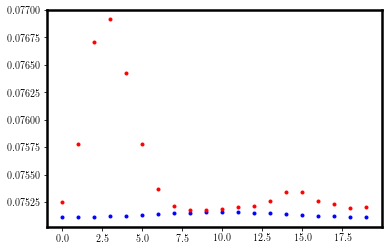

In [249]:
for i in range(0,shape(gmin_S2)[0]):
    plt.plot(i,sum(gmin_S2[i,:]),'b.')
    plt.plot(i,sum(gmin_S2_gf[i,:]),'r.')
plt.show()

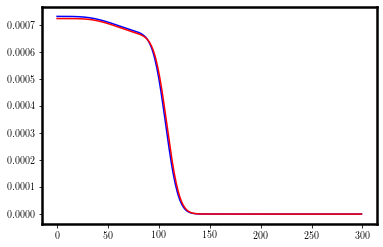

In [170]:
i = 0
plt.plot(gmin_S2[i,:],'b-')
plt.plot(gmin_S2_gf[i,:],'r-')
plt.show()

In [221]:
weights[2]

0.18630021435200653

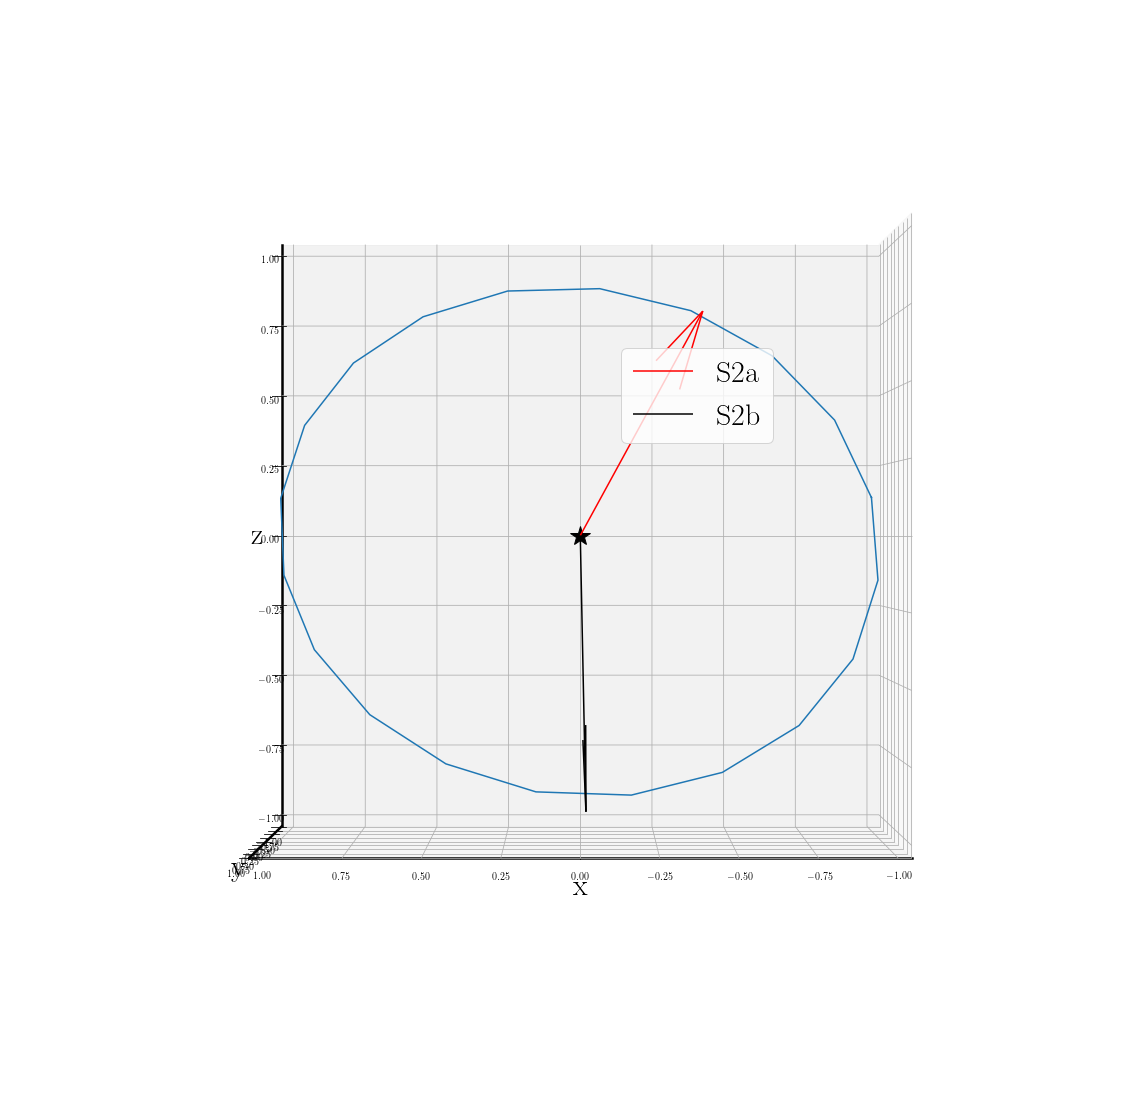

In [247]:
%matplotlib inline  

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


vsun = array([0,233,0])+v_pec

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

vec = zeros(shape=(ndays,3))
for i in range(0,ndays):
    x_earth = EarthVector1(days[i])
    r_earth = sqrt(sum(x_earth**2.0))
    x_earth /= r_earth
    vec[i,:] = x_earth

vec = vstack((vec,vec[0,:]))
ax.plot(vec[:,0], vec[:,1], vec[:,2])
ax.plot([0],[0],[0],'k*',ms=20)
plt.xlim([-1,1])
plt.ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('x',fontsize=30)
ax.set_ylabel('y',fontsize=30)
ax.set_zlabel('z',fontsize=30)

v1 = velocities[1,:]-vsun
v2 = velocities[2,:]-vsun
xS2 = v1/sqrt(sum(v1**2.0))
ax.quiver(0,0,0,xS2[0],xS2[1],xS2[2], length=1, normalize=True,color='r',label='S2a')

xS2 = v2/sqrt(sum(v2**2.0))
ax.quiver(0,0,0,xS2[0],xS2[1],xS2[2], length=1, normalize=True,color='k',label='S2b')

ax.view_init(0,90)

plt.legend(loc=1,bbox_to_anchor=(0.7,0.7),fontsize=30)
plt.show()



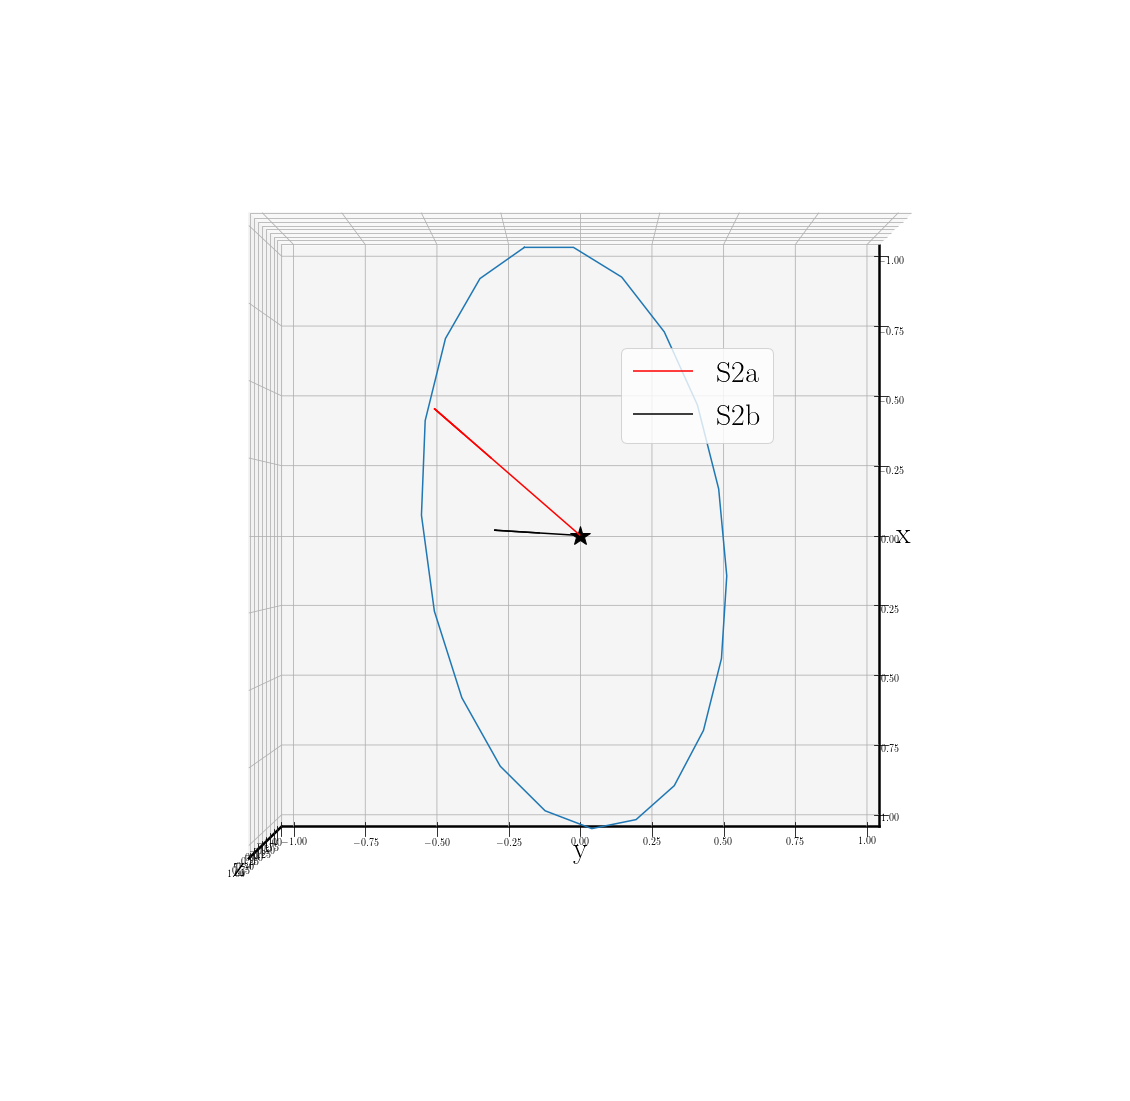

In [246]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

ax.plot(vec[:,0], vec[:,1], vec[:,2])
ax.plot([0],[0],[0],'k*',ms=20)
plt.xlim([-1,1])
plt.ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('x',fontsize=30)
ax.set_ylabel('y',fontsize=30)
ax.set_zlabel('z',fontsize=30)

v1 = velocities[1,:]-vsun
v2 = velocities[2,:]-vsun
xS2 = v1/sqrt(sum(v1**2.0))
ax.quiver(0,0,0,xS2[0],xS2[1],xS2[2], length=1, normalize=True,color='r',label='S2a')

xS2 = v2/sqrt(sum(v2**2.0))
ax.quiver(0,0,0,xS2[0],xS2[1],xS2[2], length=1, normalize=True,color='k',label='S2b')

ax.view_init(90,0)

plt.legend(loc=1,bbox_to_anchor=(0.7,0.7),fontsize=30)
plt.show()


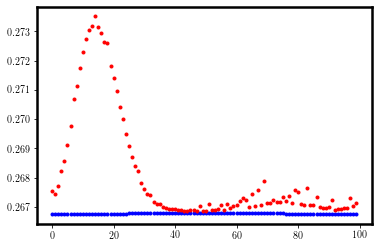

In [160]:
gmin_S2 = loadtxt('../data/gvmin/gvmin_S2.txt',skiprows=1)
gmin_S2_gf = loadtxt('../data/gvmin/gvmin_S2_gf.txt',skiprows=1)

for i in range(0,shape(gmin_S2)[0]):
    plt.plot(i,sum(gmin_S2[i,:]),'b.')
    plt.plot(i,sum(gmin_S2_gf[i,:]),'r.')
plt.show() 

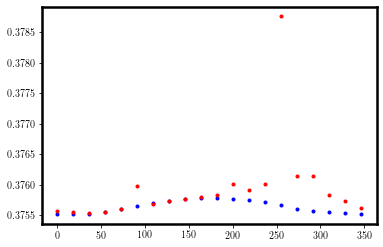

In [127]:
for i in range(0,ndays):
    plt.plot(days[i],sum(fv1[i,:]),'b.')
    plt.plot(days[i],sum(fv1_gf[i,:]),'r.')

    #plt.plot(days[i],trapz(fv1[i,:],v),'r.')

plt.show()

In [105]:
gmin_S2 = loadtxt('../data/gvmin/gvmin_S2.txt',skiprows=1)
gmin_S2_gf = loadtxt('../data/gvmin/gvmin_S2_gf.txt',skiprows=1)

for i in range(0,shape(gmin_S2)[0]):
    plt.plot(i,sum(gmin_S2[i,:]),'b.')
    plt.plot(i,sum(gmin_S2_gf[i,:]),'r.')
plt.show()

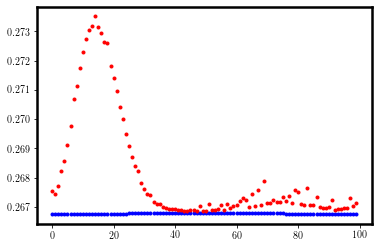

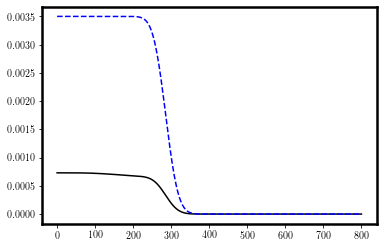

In [120]:
plt.plot(v_min_fine,gmin_S2[0,:],'k-')
plt.plot(v_min_fine,fv1[0,:],'b--')
plt.show()

In [142]:
gmin_S2 = zeros(shape=(ndays,nfine))
gmin_S2_gf = zeros(shape=(ndays,nfine))

for i in range(0,ndays):

    gmin_sub = zeros(shape=(nshards,nfine))
    gmin_sub_gf = zeros(shape=(nshards,nfine))

    for isub in range(1,4):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        gmin_sub[isub,:] = weights[isub]*gvmin_Triaxial1(v_min_fine,days[i],sig_s,v_shift=v_s)
        gmin_sub_gf[isub,:] = weights[isub]*gvmin_Triaxial1(v_min_fine,days[i],sig_s,v_shift=v_s,GravFocus=True)

    gmin_S2[i,:] = gmin_sub[1,:]+gmin_sub[2,:]
    gmin_S2_gf[i,:] = gmin_sub_gf[1,:]+gmin_sub_gf[2,:]

    print('day = ',i+1,'of',ndays)

day =  1 of 20
day =  2 of 20
day =  3 of 20
day =  4 of 20
day =  5 of 20
day =  6 of 20
day =  7 of 20
day =  8 of 20
day =  9 of 20
day =  10 of 20
day =  11 of 20
day =  12 of 20
day =  13 of 20
day =  14 of 20
day =  15 of 20
day =  16 of 20
day =  17 of 20
day =  18 of 20
day =  19 of 20
day =  20 of 20


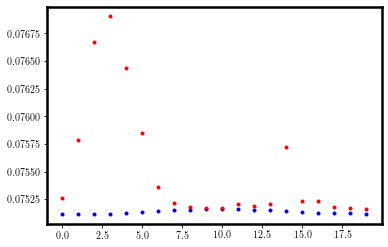

In [143]:
for i in range(0,shape(gmin_S2)[0]):
    plt.plot(i,sum(gmin_S2[i,:]),'b.')
    plt.plot(i,sum(gmin_S2_gf[i,:]),'r.')
plt.show()

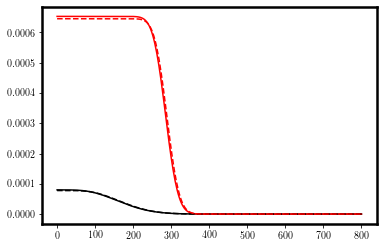

In [147]:
plt.plot(v_min_fine,gmin_sub[1,:],'k-')
plt.plot(v_min_fine,gmin_sub[2,:],'r-')

plt.plot(v_min_fine,gmin_sub_gf[1,:],'k--')
plt.plot(v_min_fine,gmin_sub_gf[2,:],'r--')

plt.show()

In [141]:
sum(gmin_sub[iS2,:],0)

0.005161653178618138